In [2]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pennylane as qml
import matplotlib.pyplot as plt


In [3]:
def extract_target_property(metadata):
    """
    Tries to extract a numerical target property from the last few lines of metadata.
    Assumes the target is the last valid float number.
    """
    target_property = np.nan  # Default to NaN in case no value is found
    
    # Traverse the metadata to find the last valid numerical value
    for line in reversed(metadata):
        for value in reversed(line.strip().split()):
            try:
                target_property = float(value)
                return target_property  # Return the first valid float found
            except ValueError:
                continue  # Skip non-numeric values
                
    return target_property  # Return NaN if no numeric value is found

In [27]:
# Directory containing the XYZ files
xyz_dir = "QM9/dsgdb9nsd.xyz"

def parse_xyz(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
        # Step 1: Get the number of atoms
        num_atoms = int(lines[0].strip())
        
        # Step 2: Extract atomic types and coordinates
        atom_types = []
        coordinates = []
        
        for i in range(2, 2 + num_atoms):
            parts = lines[i].strip().split()
            atom_types.append(parts[0])  # Atom symbol (C, H, O, etc.)
            coords = [float(part.replace('*^', 'e')) for part in parts[1:4]]
            coordinates.append(coords)
        
        # Step 3: Extract the metadata and target property
        metadata_start = 2 + num_atoms
        metadata = lines[metadata_start:]
        target_property = extract_target_property(metadata)
        #print(target_property)
        return atom_types, np.array(coordinates), target_property


In [28]:
from scipy.spatial.distance import pdist, squareform
from collections import Counter

def compute_features(atom_types, coordinates):
    # Step 1: Count the number of atoms of each type (C, H, O)
    atom_counts = Counter(atom_types)
    num_c = atom_counts.get('C', 0)
    num_h = atom_counts.get('H', 0)
    num_o = atom_counts.get('O', 0)
    
    # Step 2: Compute pairwise distances between all atoms
    pairwise_distances = squareform(pdist(coordinates))
    
    # Step 3: Compute the mean and max pairwise distances
    mean_distance = np.mean(pairwise_distances)
    max_distance = np.max(pairwise_distances)
    
    # Step 4: Return the feature vector (you can extend this as needed)
    return np.array([num_c, num_h, num_o, mean_distance, max_distance])


In [29]:
def generate_synthetic_target(features):
    # Use a linear combination of features as a temporary target
    return 0.5 * features[3] + 0.3 * features[4]  # Mean distance + max distance (adjust as needed)


In [ ]:
# Store parsed data
molecule_data = []


for file_name in os.listdir(xyz_dir):
    if file_name.endswith(".xyz"):
        file_path = os.path.join(xyz_dir, file_name)
        atom_types, coordinates, target_property = parse_xyz(file_path)
        features = compute_features(atom_types, coordinates)
        
        # If target property is NaN, generate a synthetic target
        if np.isnan(target_property):
            target_property = generate_synthetic_target(features)
        
        molecule_data.append({
            "file_name": file_name,
            "features": features,
            "target_property": target_property
        })

# Convert to DataFrame
df = pd.DataFrame(molecule_data)
print(df.head())


In [21]:


file_path = "QM9/dsgdb9nsd.xyz/dsgdb9nsd_000002.xyz"  # Adjust path if needed
with open(file_path, 'r') as f:
    lines = f.readlines()
    print("\n".join(lines[-10:]))  # Print the last 10 lines of the file


4

gdb 2	293.60975	293.54111	191.39397	1.6256	9.46	-0.257	0.0829	0.3399	26.1563	0.034358	-56.525887	-56.523026	-56.522082	-56.544961	6.316	

N	-0.0404260543	 1.0241077531	 0.0625637998	-0.707143

H	 0.0172574639	 0.0125452063	-0.0273771593	 0.235712

H	 0.9157893661	 1.3587451948	-0.0287577581	 0.235712

H	-0.5202777357	 1.3435321258	-0.7755426124	 0.23572

1103.8733	1684.1158	1684.3072	3458.7145	3575.2414	3575.3343

N	N	

InChI=1S/H3N/h1H3	InChI=1S/H3N/h1H3



In [9]:
# Check the number of NaNs in the target property
nan_count = df['target_property'].isna().sum()
total_count = len(df)

print(f"Number of NaN values in target property: {nan_count}")
print(f"Percentage of NaNs: {(nan_count / total_count) * 100:.2f}%")


Number of NaN values in target property: 0
Percentage of NaNs: 0.00%


In [10]:
# Print the last 10 lines of the first XYZ file
file_path = os.path.join(xyz_dir, "dsgdb9nsd_000001.xyz")
with open(file_path, 'r') as f:
    lines = f.readlines()
    print("".join(lines[-10:]))  # Print the last 10 lines for inspection


5
gdb 1	157.7118	157.70997	157.70699	0.	13.21	-0.3877	0.1171	0.5048	35.3641	0.044749	-40.47893	-40.476062	-40.475117	-40.498597	6.469	
C	-0.0126981359	 1.0858041578	 0.0080009958	-0.535689
H	 0.002150416	-0.0060313176	 0.0019761204	 0.133921
H	 1.0117308433	 1.4637511618	 0.0002765748	 0.133922
H	-0.540815069	 1.4475266138	-0.8766437152	 0.133923
H	-0.5238136345	 1.4379326443	 0.9063972942	 0.133923
1341.307	1341.3284	1341.365	1562.6731	1562.7453	3038.3205	3151.6034	3151.6788	3151.7078
C	C	
InChI=1S/CH4/h1H4	InChI=1S/CH4/h1H4



In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Expand the features column into a NumPy feature matrix
X = np.array([np.array(f) for f in df['features']])

# Target vector (target_property)
y = df['target_property'].values

# Split the dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features and target using StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (107108, 5)
Test set shape: (26777, 5)


More intricate circuit, with added layer of RY, RZ gates, and CNOT gates to improve the circuit’s expressiveness. also updated the weights.

In [12]:
import pennylane as qml
import numpy as np

# Number of qubits = number of features
n_qubits = X_train.shape[1]
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnn_circuit(inputs, weights):
    # =========================
    # Step 1: Input Encoding
    # =========================
    # Encode the classical data using a combination of RX, RY, and RZ rotations
    for i in range(n_qubits):
        qml.RX(inputs[i], wires=i)
        qml.RY(inputs[i] * 1.2, wires=i)  # Add scaling for diversity
        qml.RZ(inputs[i] * 0.8, wires=i)

    # =========================
    # Step 2: Layered Circuit
    # =========================
    # Add multiple layers of parameterized rotations and entanglement
    num_layers = 5  # You can experiment with more layers if your setup allows
    for layer in range(num_layers):
        # Parameterized rotations (diversify using RX, RY, RZ)
        for i in range(n_qubits):
            qml.RX(weights[layer * 3 * n_qubits + i], wires=i)
            qml.RY(weights[layer * 3 * n_qubits + n_qubits + i], wires=i)
            qml.RZ(weights[layer * 3 * n_qubits + 2 * n_qubits + i], wires=i)
        
        # Entanglement using both CNOT and CZ gates
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])  # Local entanglement
        for i in range(n_qubits):
            target = (i + 2) % n_qubits  # Entangle distant qubits
            qml.CZ(wires=[i, target])

    # =========================
    # Step 3: Measurement
    # =========================
    return qml.expval(qml.PauliZ(0))





In [13]:
# Define the Huber loss
def huber_loss(weights, X, y, delta=1.0):
    predictions = np.array([qnn_circuit(x, weights) for x in X])
    predictions = predictions.flatten()
    y = y.flatten()
    residuals = np.abs(predictions - y)
    loss = np.where(residuals <= delta, 0.5 * residuals**2, delta * residuals - 0.5 * delta**2)
    return np.mean(loss)


In [14]:
import time

# Initialize random weights
weights = np.random.randn(3 * n_qubits * 5)

# Time a single circuit evaluation
start = time.time()
single_prediction = qnn_circuit(X_train[0], weights)
end = time.time()

print(f"Time taken for a single circuit evaluation: {end - start:.4f} seconds")


Time taken for a single circuit evaluation: 0.0030 seconds


In [15]:
import time

# Select a single batch of data
batch_size = 50
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Time the forward pass and weight update
start_time = time.time()

weights = np.random.randn(3 * n_qubits * 5)
batch_loss = huber_loss(weights, X_batch, y_batch)

end_time = time.time()
print(f"Time taken for a single batch of size {batch_size}: {end_time - start_time:.4f} seconds")



Time taken for a single batch of size 50: 0.1265 seconds


In [16]:
# Test the quantum circuit with a sample input
test_output = qnn_circuit(X_train[0], weights)
print(f"Sample circuit output: {test_output}")


Sample circuit output: -0.21074040688205928


Epoch 1/20: Average Training Loss = 0.4190, Time = 1780.80 s
New best loss found: 0.4190 at epoch 1. Saving model.
Epoch 2/20: Average Training Loss = 0.4119, Time = 1311.32 s
New best loss found: 0.4119 at epoch 2. Saving model.
Epoch 3/20: Average Training Loss = 0.4097, Time = 1206.59 s
New best loss found: 0.4097 at epoch 3. Saving model.
Epoch 4/20: Average Training Loss = 0.4085, Time = 1207.52 s
New best loss found: 0.4085 at epoch 4. Saving model.
Epoch 5/20: Average Training Loss = 0.4082, Time = 1203.16 s
New best loss found: 0.4082 at epoch 5. Saving model.
Epoch 6/20: Average Training Loss = 0.4082, Time = 1205.15 s
New best loss found: 0.4082 at epoch 6. Saving model.
Epoch 7/20: Average Training Loss = 0.4081, Time = 1208.90 s
New best loss found: 0.4081 at epoch 7. Saving model.
Epoch 8/20: Average Training Loss = 0.4080, Time = 1208.53 s
New best loss found: 0.4080 at epoch 8. Saving model.
Epoch 9/20: Average Training Loss = 0.4081, Time = 1218.75 s
Epoch 10/20: Averag

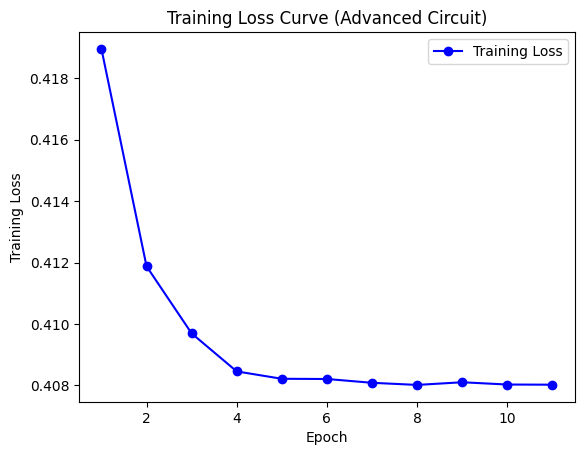

In [17]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time
import pickle  # To save the best model weights

# Initialize weights and optimizer
weights = np.random.randn(3 * n_qubits * 5)  # Match the 5-layer advanced circuit
opt = qml.AdamOptimizer(stepsize=0.01)  # Start with a lower stepsize for stable updates

# Training settings
batch_size = 50
n_epochs = 20  # Increase epochs to give the deeper circuit time to learn
decay_rate = 0.1
convergence_limit = 3  # Stop if no improvement after 4 epochs
best_loss = float('inf')  # Track the lowest loss
epochs_without_improvement = 0  # Counter for early stopping
best_weights = None  # Store the best weights

# Training loop
loss_history = []

for epoch in range(n_epochs):
    start_time = time.time()

    # Update learning rate dynamically
    current_stepsize = 0.01 / (1 + decay_rate * epoch)
    opt.stepsize = current_stepsize
    
    # Shuffle data and create mini-batches
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)
    X_train_batches = [X_train_shuffled[i:i + batch_size] for i in range(0, len(X_train_shuffled), batch_size)]
    y_train_batches = [y_train_shuffled[i:i + batch_size] for i in range(0, len(y_train_shuffled), batch_size)]
    
    epoch_losses = []

    # Iterate through mini-batches
    for X_batch, y_batch in zip(X_train_batches, y_train_batches):
        weights = opt.step(lambda w: huber_loss(w, X_batch, y_batch), weights)
        batch_loss = huber_loss(weights, X_batch, y_batch)
        epoch_losses.append(batch_loss)
    
    # Compute average loss for this epoch
    avg_epoch_loss = np.mean(epoch_losses)
    loss_history.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}: Average Training Loss = {avg_epoch_loss:.4f}, Time = {time.time() - start_time:.2f} s")

    # Check for improvement
    if avg_epoch_loss < best_loss:
        print(f"New best loss found: {avg_epoch_loss:.4f} at epoch {epoch + 1}. Saving model.")
        best_loss = avg_epoch_loss
        best_weights = weights.copy()  # Save the best weights
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1  # Increment the counter if no improvement

    # Early stopping condition
    if epochs_without_improvement >= convergence_limit:
        print(f"Stopping early at epoch {epoch + 1}. No improvement for {convergence_limit} consecutive epochs.")
        break

# Save the best model weights to a file
with open("best_qnn_weights.pkl", "wb") as f:
    pickle.dump(best_weights, f)
    print("Best model weights saved to 'best_qnn_weights.pkl'.")

# Plot the loss curve after training
plt.plot(range(1, len(loss_history) + 1), loss_history, 'b-o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve (Advanced Circuit)')
plt.legend()
plt.show()


In [22]:
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Load the best model weights
with open("best_qnn_weights.pkl", "rb") as f:
    best_weights = pickle.load(f)

# Huber loss function for evaluation
def huber_loss_test(predictions, y, delta=1.0):
    predictions = predictions.flatten()
    y = y.flatten()

    # Calculate residuals
    residuals = np.abs(predictions - y)
    
    # Apply Huber loss formula
    loss = np.where(residuals <= delta,
                    0.5 * residuals**2,
                    delta * residuals - 0.5 * delta**2)
    
    return np.mean(loss)

# Make predictions on the test set
predictions = np.array([qnn_circuit(x, best_weights) for x in X_test])

# Inverse-transform the predictions and targets back to the original scale
predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))


# IMPORTANT: The circuit output should be scaled appropriately
# Rescale predictions from [-1, 1] to the target range
predictions_scaled = scaler_y.inverse_transform(predictions.reshape(-1, 1))
y_test_scaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Check if the scales are correct
print(f"Predicted values (original scale): {predictions_scaled[:5]}")
print(f"Actual values (original scale): {y_test_scaled[:5]}")


# Calculate Huber loss on the test set
test_huber_loss = huber_loss_test(predictions_original, y_test_original)
print(f"Test Huber Loss: {test_huber_loss:.4f}")

# Optional: Evaluate with MSE and R² for comparison
mse = mean_squared_error(y_test_original, predictions_original)
r2 = r2_score(y_test_original, predictions_original)
print(f"Test MSE: {mse:.4f}")
print(f"Test R² score: {r2:.4f}")


Predicted values (original scale): [[3534.08626347]
 [3541.13513235]
 [3610.49866765]
 [3492.78708749]
 [3615.06017365]]
Actual values (original scale): [[3227.1908]
 [3808.7752]
 [3821.1362]
 [3505.7229]
 [3532.922 ]]
Test Huber Loss: 213.3869
Test MSE: 61888.5381
Test R² score: 0.1191
